In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/net/tscratch/people/plghpiotr


In [2]:
%cd cl-adaptation/

/net/tscratch/people/plghpiotr/cl-adaptation


In [3]:
import torch

torch.cuda.is_available()

True

In [4]:
import torch
from collections import defaultdict
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from src.analysis import core
import re

DEVICE = "cuda"


get_digits = lambda str: int(re.sub(r"\D", "", str))


def is_sign_changed(output_1: torch.Tensor, output_2: torch.Tensor):
    return (output_1.mean(0) * output_2.mean(0)) < 0


def sign_mass(name_path: dict, device="cpu"):
    columns = len(name_path)

    # plt.rcParams.update({"font.size": 16})

    # fig, axs = plt.subplots(1, columns, dpi=100, figsize=(columns * 5, 1 * 5))

    # train_loader, _, test_loader, taskcla = data_factory[0]
    exp_analysis = defaultdict(list)

    for col, (exp_name, exp_path) in enumerate(name_path.items()):
        print(exp_name)
        cfg = core.create_cfg(exp_path)
        # cfg.data.num_workers = 1
        data_factory = core.DataFactory(cfg)
        _, _, test_loader, taskcla = data_factory[0]
        model_factory = core.ModelFactory(cfg, exp_path, device=device)

        for task_idx, ckpt in enumerate(sorted(model_factory.ckpts)):
            assert task_idx == get_digits(ckpt.name)
            if task_idx == 0:
                model = model_factory.create_model(
                    task=task_idx, num_classes=taskcla[1]
                )
                weights = model.heads[-1].weight
                outs_0 = core.get_activations(model.model, test_loader, device=device)
                continue

            model = model_factory.create_model(task=task_idx, num_classes=taskcla[1])
            outs = core.get_activations(model.model, test_loader, device=device)
            labels_signs = {}
            for label in outs_0.keys():
                d_changed = is_sign_changed(outs_0[label], outs[label])
                labels_signs[label] = d_changed
                # print(d_changed.sum())

            sorted_signs = torch.stack(
                [value for key, value in sorted(labels_signs.items())]
            )
            changed_mass = (
                sorted_signs * weights.abs() / weights.abs().sum(1).unsqueeze(1)
            ).sum(1)
            before_sum = (
                sorted_signs * weights.abs() / weights.abs().sum(1).unsqueeze(1)
            )
            print(
                f"{sorted_signs.shape=}, {weights.shape=}, {before_sum.shape=}, {changed_mass.shape=}"
            )

            exp_analysis[exp_name].append(changed_mass.detach().cpu())
            # exp_analysis[exp_name].append(sorted_signs.sum(1).detach().cpu() / 768)
            # print(
            #     f"{changed_mass.mean().item()=:.2f} {changed_mass.min().item()=:.2f} {changed_mass.max().item()=:.2f}"
            # )
    return exp_analysis

In [5]:
from pathlib import Path

# p = Path("models/cifar100_5/resnet34")
p = Path("models/cifar100_5/convnext")
expname_path = {}
for dir in p.iterdir():
    for i in dir.iterdir():
        path = i.readlink()
        exp_name = "_".join(i.parts[2:])
        expname_path[exp_name] = path

In [6]:
expname_path

{'convnext_finetuning_reg': PosixPath('results/2024/04.24/13-34-44/0/cifar100_fixed_finetuning'),
 'convnext_finetuning_noreg': PosixPath('results/2024/04.17/18-12-39/0/cifar100_fixed_finetuning_final_checkpoint'),
 'convnext_ewc_reg': PosixPath('results/2024/04.24/13-34-32/4/cifar100_fixed_ewc'),
 'convnext_ewc_noreg': PosixPath('results/2024/04.22/23-58-48/0/cifar100_fixed_ewc_final_checkpoint'),
 'convnext_lwf_reg': PosixPath('results/2024/04.24/13-35-04/0/cifar100_fixed_lwf'),
 'convnext_lwf_noreg': PosixPath('results/2024/04.27/10-23-48/0/cifar100_fixed_lwf'),
 'convnext_replay_reg': PosixPath('results/2024/04.24/13-34-32/2/cifar100_fixed_finetuning'),
 'convnext_replay_noreg': PosixPath('results/2024/04.17/18-12-39/1/cifar100_fixed_finetuning_final_checkpoint')}

In [7]:
# expname_path = {
#     "convnext_finetuning_reg": "results/2024/04.24/13-34-44/0/cifar100_fixed_finetuning",
#     "convnext_finetuning_noreg": "results/2024/04.17/18-12-39/0/cifar100_fixed_finetuning_final_checkpoint",
#     # "convnext_ewc_reg": "results/2024/04.24/13-34-32/4/cifar100_fixed_ewc",
#     # "convnext_ewc_noreg": "results/2024/04.22/23-58-48/0/cifar100_fixed_ewc_final_checkpoint",
#     # "convnext_lwf_reg": "results/2024/04.24/13-35-04/0/cifar100_fixed_lwf",
#     # "convnext_lwf_noreg": "results/2024/04.27/10-23-48/0/cifar100_fixed_lwf",
#     # "convnext_replay_reg": "results/2024/04.24/13-34-32/2/cifar100_fixed_finetuning",
#     # "convnext_replay_noreg": "results/2024/04.17/18-12-39/1/cifar100_fixed_finetuning_final_checkpoint",
# }

In [8]:
finetuning_exps = {
    # "resnet34_finetuning_reg": "results/2024/04.24/13-35-10/0/cifar100_fixed_finetuning",
    "resnet34_finetuning_noreg": "results/2024/04.17/18-13-25/0/cifar100_fixed_finetuning_final_checkpoint",
}

In [9]:
exp_analysis = sign_mass(expname_path, DEVICE)
# exp_analysis = sign_mass(
#     dict(filter(lambda x: "finetuning" in x[0], expname_path.items())), DEVICE
# )

convnext_finetuning_reg
Files already downloaded and verified
Files already downloaded and verified


/net/tscratch/people/plghpiotr/.conda/mgr_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/net/tscratch/people/plghpiotr/.conda/mgr_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.01it/s]


<All keys matched successfully>


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 14.10it/s]


sorted_signs.shape=torch.Size([20, 768]), weights.shape=torch.Size([20, 768]), before_sum.shape=torch.Size([20, 768]), changed_mass.shape=torch.Size([20])
<All keys matched successfully>


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.29it/s]


sorted_signs.shape=torch.Size([20, 768]), weights.shape=torch.Size([20, 768]), before_sum.shape=torch.Size([20, 768]), changed_mass.shape=torch.Size([20])


KeyboardInterrupt: 

In [23]:
exp_analysis.keys()

dict_keys(['convnext_finetuning_reg', 'convnext_finetuning_noreg', 'convnext_ewc_reg', 'convnext_ewc_noreg', 'convnext_lwf_reg', 'convnext_lwf_noreg', 'convnext_replay_reg', 'convnext_replay_noreg'])

In [45]:
exp_analysis["convnext_finetuning_reg"]

[tensor([0.2344, 0.2526, 0.3268, 0.2799, 0.3099, 0.2305, 0.2552, 0.2253, 0.2122,
         0.2591, 0.2591, 0.2370, 0.2240, 0.2461, 0.2604, 0.2227, 0.2383, 0.2357,
         0.2435, 0.2331]),
 tensor([0.2513, 0.3203, 0.3620, 0.3372, 0.3281, 0.2943, 0.3190, 0.3034, 0.3034,
         0.3034, 0.2995, 0.2904, 0.3008, 0.3294, 0.3164, 0.2695, 0.3021, 0.2956,
         0.3216, 0.2865]),
 tensor([0.3398, 0.4036, 0.3633, 0.4010, 0.3828, 0.3411, 0.3893, 0.3294, 0.3177,
         0.3529, 0.3789, 0.3464, 0.3464, 0.3216, 0.4141, 0.3229, 0.3216, 0.3424,
         0.3698, 0.3620]),
 tensor([0.3555, 0.3919, 0.3906, 0.3854, 0.3737, 0.3932, 0.3698, 0.3867, 0.3490,
         0.3672, 0.4258, 0.3789, 0.3685, 0.3802, 0.3945, 0.3724, 0.3919, 0.3763,
         0.3932, 0.3893])]

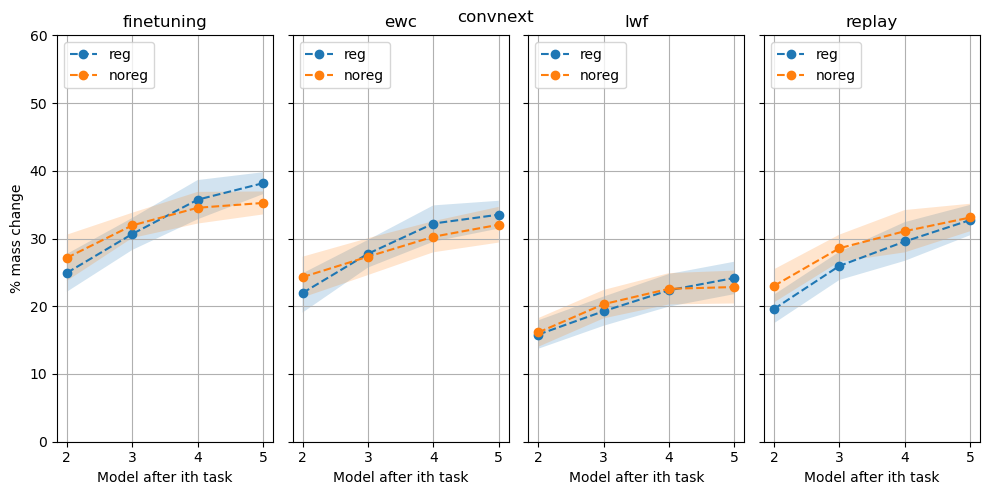

In [48]:
import re

import matplotlib as mpl

# mpl.rcParams["text.usetex"] = False
# mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
# nice_fonts = {
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": "Times New Roman",
#     "font.size": 14,
#     "lines.linewidth": 3,
# }
# mpl.rcParams.update(nice_fonts)


def plt_subplots(exp_analysis):
    methods_pattern = re.compile(r"^.*_(.*)_")
    methods = set([methods_pattern.match(key).group(1) for key in exp_analysis.keys()])
    fig, axs = plt.subplots(1, len(methods), figsize=(10, 5))
    if len(methods) == 1:
        axs = [axs]
    for i, method in enumerate(methods):
        exp_names = [exp_name for exp_name in exp_analysis.keys() if method in exp_name]
        for name in exp_names:
            arr = (
                np.array([task_a.detach().cpu() for task_a in exp_analysis[name]]) * 100
            )
            *net_name, method_name, is_reg_name = name.split("_")

            steps = range(2, arr.shape[0] + 2)
            axs[i].plot(steps, arr.mean(1), "o--", label=is_reg_name)
            axs[i].fill_between(
                steps,
                arr.mean(1) - arr.std(1),
                arr.mean(1) + arr.std(1),
                # color="gray",
                alpha=0.2,
            )
            axs[i].set_ylim([0, 60])
            axs[i].set_xticks(steps)
            axs[i].legend(loc="upper left", fancybox=True, shadow=False)
            axs[i].grid(b=True, which="major", linestyle="-")
            axs[i].set_title(method_name)
        if i == 0:
            axs[i].set_ylabel("% mass change")
        else:
            axs[i].set(ylabel="", yticklabels=[])
        axs[i].set_xlabel("Model after ith task")
    fig.tight_layout()
    fig.suptitle(" ".join(net_name))
    plt.show()


plt_subplots(exp_analysis)

In [ ]:
exp_analysis

In [ ]:
torch.save(exp_analysis, "exp_analysis.pkl")

In [ ]:
exp_analysis

In [ ]:
plt.figure(figsize=(10, 8))
plt.rcParams.update({"font.size": 16})
for exp_name, task_analysis in exp_analysis.items():
    arr = np.array([task_a.detach().cpu() for task_a in task_analysis]) * 100
    marker = "o-" if "noreg" in exp_name else "o--"
    steps = list(range(2, len(task_analysis) + 2))
    plt.plot(steps, arr.mean(1), marker, label=exp_name)
    plt.fill_between(
        steps,
        arr.mean(1) - arr.std(1),
        arr.mean(1) + arr.std(1),
        # color="gray",
        alpha=0.2,
    )
plt.legend(loc="upper left", fancybox=True, shadow=False)
plt.grid()
plt.tight_layout()
plt.xticks(steps)
plt.xlabel("Model wytrenowany po i-tym zadaniu")
plt.ylabel("% masy zmiany znaku wag")
# plt.title("Ważona zmiana znaku wektora cech na danych z pierwszego zadania")
plt.ylim(0, 45)

In [ ]:
exp_analysis